c:\users\ict_lab\desktop\pythonproject\convr2022\venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


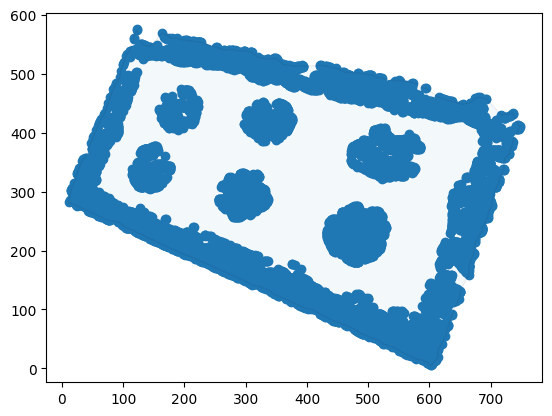

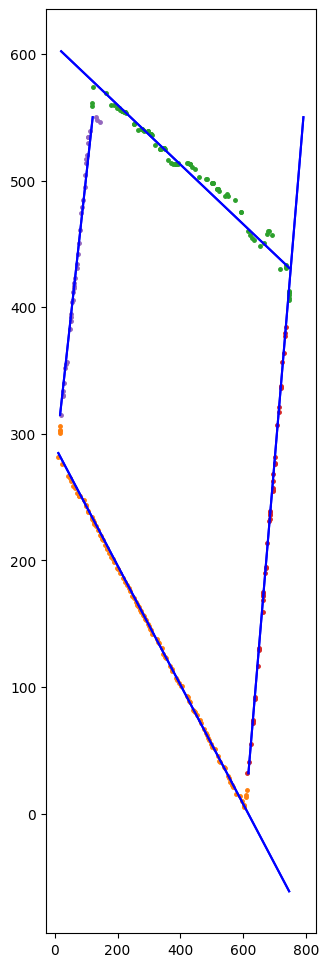

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import LineModelND, ransac

# 0. Data reading
dir = "../cropped_prof.jpg"
src = cv2.imread(dir)

# 0-1 BGR 값 inRange
dst = cv2.inRange(src, (50, 130, 120), (110, 140, 160)) # range 내의 pixel을 255로 치환
src = np.where(dst == 255)
idx_x = np.array(src[0])
idx_y = np.array(src[1])
idx_xy = np.stack((idx_x, idx_y), axis=1)

# 1. Alphashape - Concave hull

import alphashape
from descartes import PolygonPatch

points = idx_xy.copy()
fig, ax = plt.subplots()
alpha = 0.05
alpha_shape = alphashape.alphashape(points, alpha)
ax.scatter(*zip(*points))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.05))
plt.show()
x, y = alpha_shape.exterior.coords.xy # alphashape xy split
x_data = np.array(x)
y_data = np.array(y)

# 2. Ransac Line Fitting

x_data_ex = np.expand_dims(x_data, axis=1)
y_data_ex = np.expand_dims(y_data, axis=1)
point_data = np.hstack((x_data_ex, y_data_ex))
plt.figure(figsize=(16,12))
plt.subplot(1,4,3)
plt.scatter(x_data, y_data, marker='.', s=3)
x_data_tmp = x_data.copy()
y_data_tmp = y_data.copy()
ransac_line = []

def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def plot_ransac_revised(segment_data_x, segment_data_y):
    data = np.column_stack([segment_data_x, segment_data_y])

    # fit line using all data
    model = LineModelND()
    model.estimate(data)

    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                                   residual_threshold=20, max_trials=1000)
    outliers = inliers == False

    # generate coordinates of estimated models
    line_x = np.array([segment_data_x.min(), segment_data_x.max()])
    line_y = model.predict_y(line_x)
    line_y_robust = model_robust.predict_y(line_x)
    k = (line_y_robust[1] - line_y_robust[0])/(line_x[1]- line_x[0])
    m = line_y_robust[0] - k*line_x[0]
    x0 = (segment_data_y.min() - m)/k
    x1 = (segment_data_y.max() - m)/k
    line_x_y = np.array([x0, x1])
    line_y_robust_y = model_robust.predict_y(line_x_y)
    if (distance(line_x[0], line_y_robust[0], line_x[1], line_y_robust[1]) <
    distance(line_x_y[0], line_y_robust_y[0], line_x_y[1], line_y_robust_y[1])):
        plt.plot(line_x, line_y_robust, '-b', label='Robust line model')
        line_twopoint = (line_x, line_y_robust)
    else:
        plt.plot(line_x_y, line_y_robust_y, '-b', label='Robust line model')
        line_twopoint = (line_x_y, line_y_robust_y)

    return inliers, outliers, line_twopoint

def line_intersection(line1, line2, x_min, x_max, y_min, y_max):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    # 범위 내의 값인지 체크
    if x_min -100 <= x <= x_max+ 100 and y_min - 100 <= y <= y_max + 100:
        return x, y
    else:
        return -12345, -12345

# 3. Ransac
while True:
    inliers, outliers, line_twopoint = plot_ransac_revised(x_data_tmp, y_data_tmp)

    if x_data_tmp[inliers].shape[0] >= 2:
        # inliers, two points for line 기록 저장
        ransac_line.append((x_data_tmp[inliers], y_data_tmp[inliers], line_twopoint))
        plt.plot(line_twopoint[0], line_twopoint[1], '-b', label='Robust line model')
        plt.scatter(x_data_tmp[inliers], y_data_tmp[inliers], marker='.', s=25)
        # plt.show()

    # 나머지 점들 (outliers)
    x_data_tmp = x_data_tmp[outliers]
    y_data_tmp = y_data_tmp[outliers]

    if x_data_tmp.shape[0] <= 2:
        break

# plt.show()

# 4. Intersection points
intersection_points = []
x_min, x_max, y_min, y_max = x_data.min(), x_data.max(), y_data.min(), y_data.max()
for i in range(len(ransac_line)):
    for j in range(i+1, len(ransac_line)):
        (x1, x2), (y1, y2)= ransac_line[i][2]
        (x3, x4), (y3, y4)= ransac_line[j][2]
        x, y = line_intersection([[x1, y1], [x2, y2]], [[x3, y3], [x4, y4]], x_min, x_max, y_min, y_max)
        # plt.plot([x1, x2], [y1, y2])
        # plt.plot([x3, x4], [y3, y4])
        if x != -12345 or y != -12345:
            intersection_points.append(np.array((x,y)))

# 5. Homography
width, height = 772, 578
pts = []
for k in range(0,4):
    np.float32(pts.append(intersection_points[k]))
pts1 = np.float32(pts)

img = cv2.imread(dir)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
img = cv2.flip(img, 0)
for x in range(0,4):
    img = cv2.circle(img, (int(pts1[x][0]),int(pts1[x][1])), 5 , (0,0,255), cv2.FILLED)
# cv2.imshow("original", img)

pts2 = np.float32([
    [width, 0],
    [0, 0],
    [width, height],
    [0, height],
    ])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgOutput = cv2.warpPerspective(img, matrix, (width, height))
imgOutput = cv2.resize(imgOutput, (600,300))

# 6. binarization

imgOutput = cv2.cvtColor(imgOutput, cv2.COLOR_BGR2HSV)
# cv2.imwrite('./hsv.jpg',imgOutput)
imgOutput = cv2.inRange(imgOutput, (0, 0, 0), (200, 15, 200))
# cv2.imwrite('./inrange_2.jpg',imgOutput)
# cv2.imshow("binarization", imgOutput)
# cv2.waitKey(0)

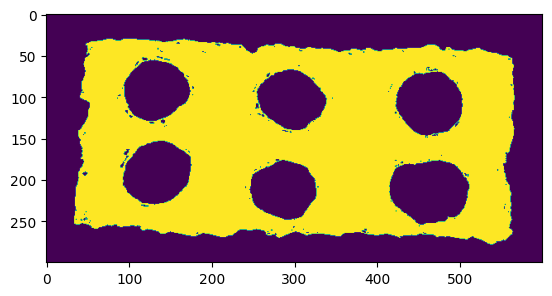

In [4]:
plt.imshow(imgOutput)

In [12]:
adhere = np.sum(imgOutput == 0)
background = np.sum(imgOutput == 255)
print("adhere", adhere)
print("background", background)
print("insulation", adhere+background)
print("percent", round((adhere*100/(adhere+background)), 2),"%")

adhere 91497
background 88503
insulation 180000
percent 50.83 %
